In [ ]:
!pip install dalle2_pytorch==1.1.0

In [ ]:
!git clone https://github.com/LAION-AI/dalle2-laion.git

In [ ]:
import torchы
from torchvision.transforms import ToPILImage
from dalle2_pytorch import DiffusionPrior, DiffusionPriorNetwork, OpenAIClipAdapter, Decoder, DALLE2
from dalle2_pytorch import OpenAIClipAdapter
from dalle2_pytorch.train_configs import TrainDiffusionPriorConfig, TrainDecoderConfig
from dalle2_pytorch.tokenizer import tokenizer

In [ ]:
prior_config = TrainDiffusionPriorConfig.from_json_path("/content/drive/MyDrive/prior_config.json").prior
prior = prior_config.create().cuda()

prior_model_state = torch.load("/content/drive/MyDrive/best.pth")
prior.load_state_dict(prior_model_state, strict=True)

In [ ]:
decoder_config = TrainDecoderConfig.from_json_path("/content/drive/MyDrive/decoder_config.json").decoder
decoder = decoder_config.create().cuda()

decoder_model_state = torch.load("/content/drive/MyDrive/latest.pth")["model"]

for k in decoder.clip.state_dict().keys():
    decoder_model_state["clip." + k] = decoder.clip.state_dict()[k]

decoder.load_state_dict(decoder_model_state, strict=True)

Shape of the image tensor: torch.Size([1, 3, 224, 224])


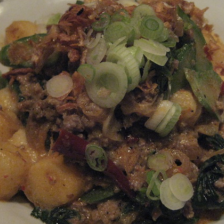

In [ ]:
import torch
from torchvision import transforms
from PIL import Image

image_path = '/content/drive/MyDrive/coco2.jpg'
text = 'a white plate of food that includes onions and meat.'
text = tokenizer.tokenize(text).cuda()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

img_pil = Image.open(image_path)

img_tensor = preprocess(img_pil).unsqueeze(0).cuda()

print("Shape of the image tensor:", img_tensor.shape)

ToPILImage()(img_tensor[0])

In [ ]:
# Лучший подход
image_embed_from_image, _ = prior.clip.embed_image(img_tensor)

image_embed_from_text = prior.sample(text, num_samples_per_batch = 2, cond_scale = 2.).cuda()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

similarity = cosine_similarity(
    image_embed_from_text.cpu(),
    image_embed_from_image.cpu()
).item()

print(image_embed_from_image.shape)
print(image_embed_from_text.shape)

print(similarity)

In [ ]:
images = decoder.sample(
    image_embed=(image_embed_from_image + image_embed_from_text) / 2,
    text=text,
    cond_scale=2.,
)

img = ToPILImage()(images[0])

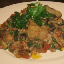

In [ ]:
# text = Токены текста (text)
# image_embed = Эмбэддинг картинки от клипа (image_embed_from_image)
img

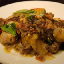

In [ ]:
# text = Токены текста (text)
# image_embed = Среднее арифметическое эмбэддинга картинки от клипа и от приора ((image_embed_from_image + image_embed_from_text) / 2)
img

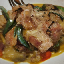

In [ ]:
# text = Токены текста (text)
# image_embed = Формула ((image_embed_from_image + similarity.item() * image_embed_from_text) / (1 + similarity.item()))
img